In [1]:
!pip install git+https://github.com/zhy0/dmarket_rl
!pip install ray[rllib]

  Cloning https://github.com/zhy0/dmarket_rl to /tmp/pip-req-build-h87of52b
  Running command git clone -q https://github.com/zhy0/dmarket_rl /tmp/pip-req-build-h87of52b
     |████████████████████████████████| 20.0MB 2.8MB/s 
  Created wheel for dmarket: filename=dmarket-0+untagged.29.g8fdcb89-cp36-none-any.whl size=11625 sha256=9c39286e3ce992fc8fa926ba75148a15298ebc9ee1b20f4b0a7d6f8d578f630a
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1nfvhwi/wheels/10/ff/93/9ad42a43b72f3601e0af83027a619401a29561fe0423318dd2
Successfully built dmarket
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: tsfresh 0.12.0 has requirement pandas<=0.23.4,>=0.20.3, but you'll have pandas 0.25.2 which is incompatible.
ERROR: tensorflow-probability 0.8.0 has requirement cloudpickle==1.1.1, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have ma

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from dmarket.environments import MultiAgentTrainingEnv
from dmarket.info_settings import BlackBoxSetting
from dmarket.agents import GymRLAgent

from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.agents import dqn

from gym.spaces import Box, Discrete

In [4]:
class MultiWrapper(MultiAgentTrainingEnv, MultiAgentEnv):
    def __init__(self, env_config):
        super().__init__(**env_config)


In [5]:
rl_agents = [
    GymRLAgent('seller', 90, 'S1', max_factor=0.25, discretization=20),
    GymRLAgent('seller', 90, 'S2', max_factor=0.25, discretization=20),
    GymRLAgent('seller', 90, 'S3', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B1', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B2', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B3', max_factor=0.25, discretization=20),
]

fixed_agents = []
setting = BlackBoxSetting()
env = MultiAgentTrainingEnv(rl_agents, fixed_agents, setting) 

In [6]:
my_policy = (None, env.observation_space, Discrete(20), {}) 

def select_policy(agent_id):
    """This function maps the agent id to the policy id"""
    return agent_id

# We name our policies the same as our RL agents
policies = {
    'S1': my_policy,
    'S2': my_policy,
    'S3': my_policy,
    'B1': my_policy,
    'B2': my_policy,
    'B3': my_policy,
}

In [7]:
EXP_NAME = "multi_3v3_blackbox"

In [8]:
import ray
ray.init(memory=12 * 1024 * 1024 * 1024)

2019-12-06 12:35:26,823	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-06 12:35:26,827	INFO resource_spec.py:205 -- Starting Ray with 11.96 GiB memory available for workers and up to 4.52 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-12-06 12:35:27,143	WARNING services.py:1288 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 2147483648 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '172.19.1.2',
 'redis_address': '172.19.1.2:62139',
 'object_store_address': '/tmp/ray/session_2019-12-06_12-35-26_825585_13/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-12-06_12-35-26_825585_13/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-12-06_12-35-26_825585_13'}

In [9]:
def run_experiment(iterations):
    trainer = dqn.DQNTrainer(env=MultiWrapper, config={
        "env_config": {"rl_agents": rl_agents, "fixed_agents": fixed_agents, "setting": setting},
        "log_level": "ERROR",
        #"num_workers": 2,
        "timesteps_per_iteration": 30,
        "multiagent": {
            "policies": policies,
            "policy_mapping_fn": select_policy
        }
    })
    rewards = []
    episodes = []
    episode_len = []
    for i in range(iterations):
        result = trainer.train()
        rewards.append(result['policy_reward_mean'])
        episodes.append(result['episodes_total'])
        episode_len.append(result['episode_len_mean'])
    
    df = pd.DataFrame(rewards, index=episodes)
    df.index.name = 'Episodes'
    df['episode_len'] = episode_len
    return df, trainer

In [10]:
def get_table(trainer, agent_id):
    policy = trainer.get_policy(agent_id)
    assert agent_id in env.rl_agents
    rl = env.rl_agents[agent_id]
    prices = np.array([
        [rl.action_to_price(action)] for action in range(rl.discretization)
    ])
    q_table = policy.compute_actions(rl.normalize(prices))[2]['q_values']
    df = pd.DataFrame(q_table, index=prices.flatten())
    df.columns = prices.flatten()
    df.index.name = "Last offer"
    df.div(df.sum(axis=1), axis=0)
    return df

In [11]:
!mkdir -p  qtables

2019-12-06 12:35:29,552	INFO trainer.py:345 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2019-12-06 12:35:50,555	INFO trainable.py:102 -- _setup took 20.971 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  rounds to the nearest even value. Thus 1.5 and 2.5 round to 2.0,
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  return ufunc(*args, out=out, **kwargs)


CPU times: user 43min 23s, sys: 3min 33s, total: 46min 57s
Wall time: 37min 3s


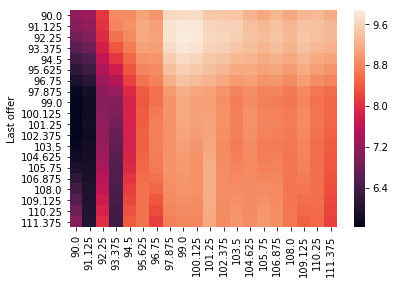

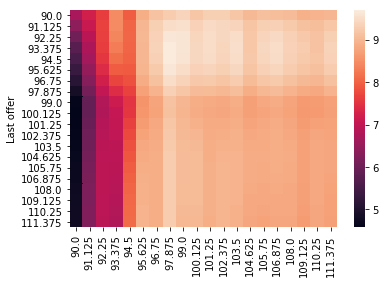

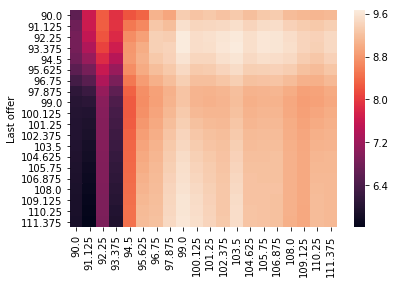

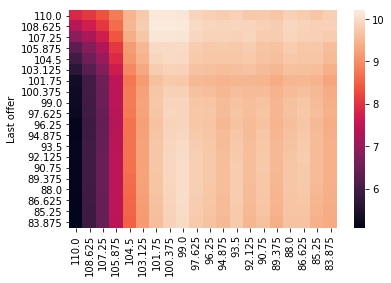

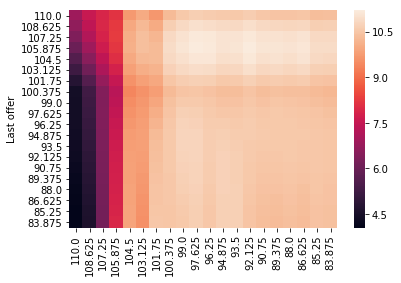

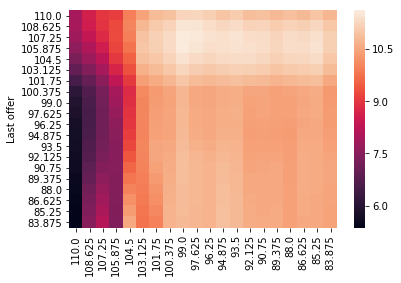

<Figure size 432x288 with 0 Axes>

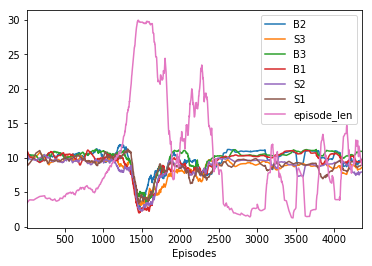

In [12]:
%%time
N_iter = 1000
runs = 1
for i in range(runs):
    result, trainer = run_experiment(N_iter)
    for agent_id in env.rl_agents.keys():
        q_table = get_table(trainer, agent_id)
        q_table.to_csv(f'qtables/{agent_id}_run{i}.csv')
        plt.figure()
        sns.heatmap(q_table)
    plt.figure()
    result.plot()
    result.to_csv(f'{EXP_NAME}_iter{N_iter}_run{i}.csv')

In [13]:
trainer

In [14]:
!du -sh /tmp

29M	/tmp
